This notebook reproduces the figures in the Data section of the report.

In [3]:
# Importing modules to access and visualise data
import xarray as xr # used for netcdf and h5 files, climate data
import h5py as h5
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfea
from pyproj import Transformer
import pyproj
import datetime
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import os, sys
from matplotlib.colors import LinearSegmentedColormap

In [11]:
def load_MISR(year):
    '''Loads MISR data and coordinates from specified file path.

    Params:
        MISR_path (str): the file path from which to retrieve data

    Returns:
        data (np.array): roughness data retrieved from the specified file
        lon, lat (np.array): longitude and latitude of grid cells
        x, y (np.array): x and y coordinates of grid cells
    '''
    path = f'/home/htweedie/melt_ponds/data/roughness_monthly_average/April_{year}_Roughness.h5'
    file = h5.File(path, 'r')
    
    # extract coord data
    lon = np.array(file['GeoLocation']['Longitude'])[::8,::8]
    lat = np.array(file['GeoLocation']['Latitude'])[::8,::8]
    x = np.array(file['GeoLocation']['x'])[::8,::8]
    y = np.array(file['GeoLocation']['y'])[::8,::8]

    # extract roughness data
    data = np.array(file['Roughness']['Roughness_2D_svm'])    [::8,::8]
    
    file.close()

    return data, lon, lat, x, y


def LOAD_MISR_H5(MISR_path):
    file_path = MISR_path
    file = h5.File(file_path, 'r')
    roughness = file['Roughness']['Roughness_2D_svm']
    data = np.array(roughness)
    file.close()
    
    return data


def MISR_COORDS(MISR_path):
    file_path = MISR_path
    file = h5.File(file_path, 'r')
    lon_MISR = np.array(file['GeoLocation']['Longitude'])
    lat_MISR = np.array(file['GeoLocation']['Latitude'])
    x_MISR = np.array(file['GeoLocation']['x'])
    y_MISR = np.array(file['GeoLocation']['y'])
    file.close()
    
    return lon_MISR, lat_MISR, x_MISR, y_MISR


def load_static_MISR(year):
    SPACING = 8
    misr_path = f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5'
    lon_MISR, lat_MISR, x_MISR, y_MISR = MISR_COORDS(misr_path)

    april_MISR = LOAD_MISR_H5(misr_path)[::SPACING,::SPACING]
    lon_MISR = lon_MISR[::SPACING,::SPACING]
    lat_MISR = lat_MISR[::SPACING,::SPACING]
    x_MISR = x_MISR[::SPACING,::SPACING]
    y_MISR = y_MISR[::SPACING,::SPACING]

    return april_MISR, lon_MISR, lat_MISR, x_MISR, y_MISR


def load_advected_MISR(year):
    return np.load(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mean_summer_sir_{year}.npy').reshape(1000,1000)


def interpolate_to_MISR(x_in, y_in, data, x_out, y_out):
    '''
    Interpolates data of the shape x_in, y_in to the shape of x_out, y_out.
    
    Params:
        data: the data to be interpolated
        x_in, y_in: the shape of the data to be interpolated
        
    Returns:
        x_out, y_out: the shape to which the data will be interpolated'''
    return griddata((x_in.ravel(), y_in.ravel()), data.ravel( ), (x_out.ravel(), y_out.ravel()), 'nearest').reshape(8000,8000) 


def WGS84toEASE2N(lon, lat):
    '''Converts WGS84 coordinates to EASE2N.

    Params:
        lon (array): the WGS84 longitude to convert
        lat (array): the WGS84 latitude to convert

    Returns:
        (x, y): the corresponding EASE2N x and y coordinates
    '''

    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


def read_list(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


# custom function to pass to statistic 
def nanmean(x):
    return np.nanmean(x)


def calculate_binned_averages(mpf, MISR, lat_MISR):

    # Create masks for valid data in each array
    mask1 = ~np.isnan(mpf)  # Invert the NaN values to get a mask of valid data
    mask2 = ~np.isnan(MISR)

    # Create a joint mask where both arrays have valid data
    joint_mask = mask1 & mask2

    # Use the joint mask to apply the mask to both arrays and corresponding latitude
    masked_mpf = np.ma.masked_array(mpf, mask=~joint_mask)
    masked_MISR = np.ma.masked_array(MISR, mask=~joint_mask)
    masked_lat_MISR = np.ma.masked_array(lat_MISR, mask=~joint_mask)

    mpf = masked_mpf.ravel()
    roughness = masked_MISR.ravel()
    lat = masked_lat_MISR.ravel()

    # Define the number of bins for latitude and roughness
    num_lat_bins = 30
    num_rough_bins = 20

    # Calculate the 2D binning and get the average values of mpf in each bin
    averages, _, _, _ = binned_statistic_2d(
        lat,
        roughness,
        mpf,
        statistic = nanmean,
        bins=[num_lat_bins, num_rough_bins],
        range=[[60, 90], [0, 0.5]]
    )

    return averages


def perc_diff(predicted, observed):
    return (predicted - observed) / ((predicted + observed) / 2) * 100


def plot_bins(binned_stats, col, min, max, title, label_size, title_size, colorbar=True, colorbar_title=""):
    y_tick_positions = np.linspace(0, 30, 7) 
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) 
    x_tick_labels = np.linspace(0, 0.5, 5)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude", fontsize=label_size)
    plt.xlabel("Roughness", fontsize=label_size)

    plt.pcolor(binned_stats, cmap=col, vmin=min, vmax=max)
    plt.title(title, fontsize=title_size)

    if colorbar:
        cbar = plt.colorbar()
        cbar.set_label(colorbar_title, fontsize=label_size)


In [3]:
# retrieve MPF coordinates
coord_fn = '/home/htweedie/melt_ponds/data/OLCI/olci/LongitudeLatitudeGrid-n12500-Arctic.h5'
coords = h5.File(coord_fn, 'r')
mpf_lon =  np.array(coords['Longitudes'])
mpf_lat = np.array(coords['Latitudes'])
x_mpf, y_mpf = WGS84toEASE2N(mpf_lon, mpf_lat)

/tmp/ipykernel_223860/4096239747.py:55: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


### Plot two sample days for MPF:

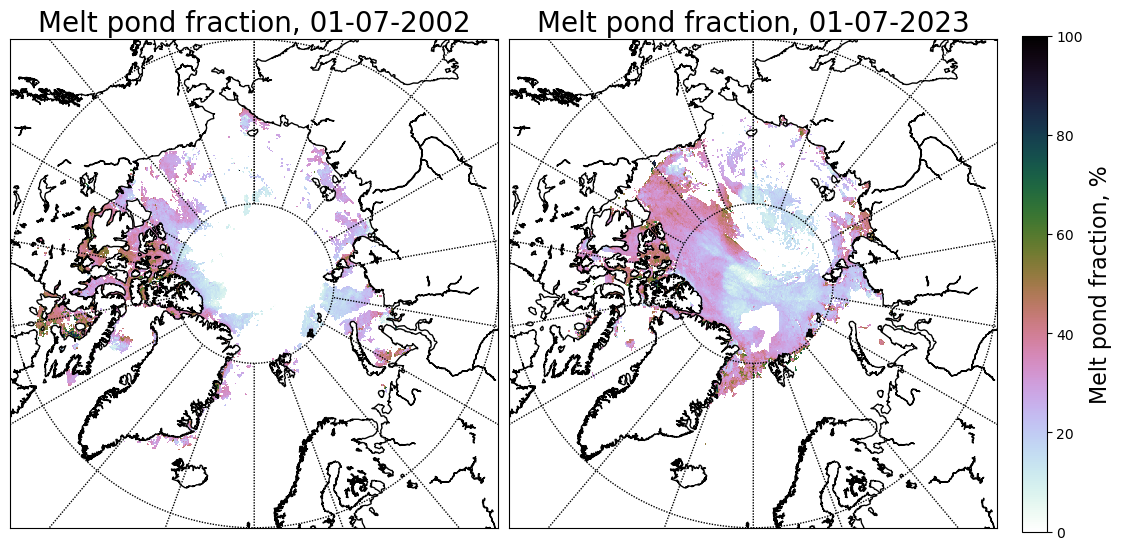

In [24]:
# load data to plot
YEAR_1=2002
MONTH_1='07'
DAY_1='01'

YEAR_2=2023
MONTH_2='07'
DAY_2='01'

if YEAR_1 >= 2017 and YEAR_1 <= 2023:
    fn_1 = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR_1}/data/mpd1_{YEAR_1}{MONTH_1}{DAY_1}.nc'
elif YEAR_1 >= 2002 and YEAR_1 <= 2011:
    fn_1 = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR_1}/data/mpd1_{YEAR_1}{MONTH_1}{DAY_1}.nc'

if YEAR_2 >= 2017 and YEAR_2 <= 2023:
    fn_2 = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR_2}/data/mpd1_{YEAR_2}{MONTH_2}{DAY_2}.nc'
elif YEAR_2 >= 2002 and YEAR_2 <= 2011:
    fn_2 = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR_2}/data/mpd1_{YEAR_2}{MONTH_2}{DAY_2}.nc'

ds_1 = xr.open_dataset(fn_1)
ds_2 = xr.open_dataset(fn_2)
mpf_1 = (ds_1['mpf'])
mpf_2 = (ds_2['mpf'])

fig = plt.figure(figsize=(16,10), layout='constrained')
plt.set_cmap('cubehelix_r')

ax = fig.add_subplot(131)
ax.set_title(f'Melt pond fraction, {DAY_1}-{MONTH_1}-{YEAR_1}', fontsize=20)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

lon_map,lat_map = m(mpf_lon,mpf_lat)
m.pcolormesh(lon_map, lat_map, mpf_1*100, vmin=0, vmax=100)
#cbar=plt.colorbar(shrink=0.4, ticks = [0, 20, 40, 60, 80, 100])
#cbar.set_label('Melt pond fraction, %')

ax = fig.add_subplot(132)
ax.set_title(f'Melt pond fraction, {DAY_2}-{MONTH_2}-{YEAR_2}', fontsize=20)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

lon_map,lat_map = m(mpf_lon,mpf_lat)
m.pcolormesh(lon_map, lat_map, mpf_2*100, vmin=0, vmax=100)
cbar=plt.colorbar(shrink=0.5, ticks = [0, 20, 40, 60, 80, 100])
cbar.set_label('Melt pond fraction, %', fontsize=16)

plt.show()


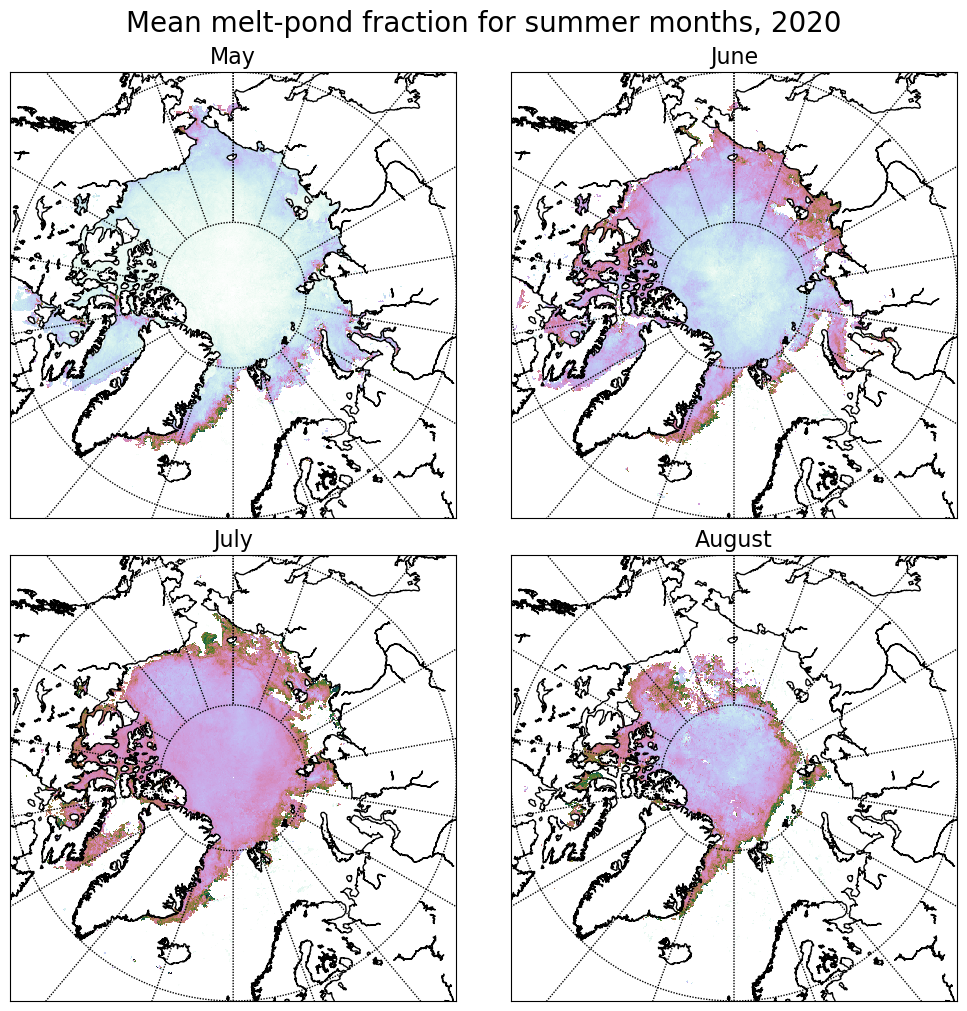

In [29]:
# load data to plot
may_mpf = np.load(f'/home/htweedie/melt_ponds/data/OLCI/olci/2020/mean_05_2020.npy')
jun_mpf = np.load(f'/home/htweedie/melt_ponds/data/OLCI/olci/2020/mean_06_2020.npy')
jul_mpf = np.load(f'/home/htweedie/melt_ponds/data/OLCI/olci/2020/mean_07_2020.npy')
aug_mpf = np.load(f'/home/htweedie/melt_ponds/data/OLCI/olci/2020/mean_08_2020.npy')

fig = plt.figure(figsize=(10,10), layout='constrained')
plt.set_cmap('cubehelix_r')

ax = fig.add_subplot(221)
ax.set_title(f'May', fontsize=16)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

lon_map,lat_map = m(mpf_lon,mpf_lat)
m.pcolormesh(lon_map, lat_map, may_mpf*100, vmin=0, vmax=100)


ax = fig.add_subplot(222)
ax.set_title(f'June', fontsize=16)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

m.pcolormesh(lon_map, lat_map, jun_mpf*100, vmin=0, vmax=100)


ax = fig.add_subplot(223)
ax.set_title(f'July', fontsize=16)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

m.pcolormesh(lon_map, lat_map, jul_mpf*100, vmin=0, vmax=100)


ax = fig.add_subplot(224)
ax.set_title(f'August', fontsize=16)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

m.pcolormesh(lon_map, lat_map, aug_mpf*100, vmin=0, vmax=100)

plt.suptitle('Mean melt-pond fraction for summer months, 2020', fontsize=20)
plt.show()


### Plot the summer mean of all the years available:

2002...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2003...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2004...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2005...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2006...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2007...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2008...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2009...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2010...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2011...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2017...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2018...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2019...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2020...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2021...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2022...


/tmp/ipykernel_223860/819676564.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


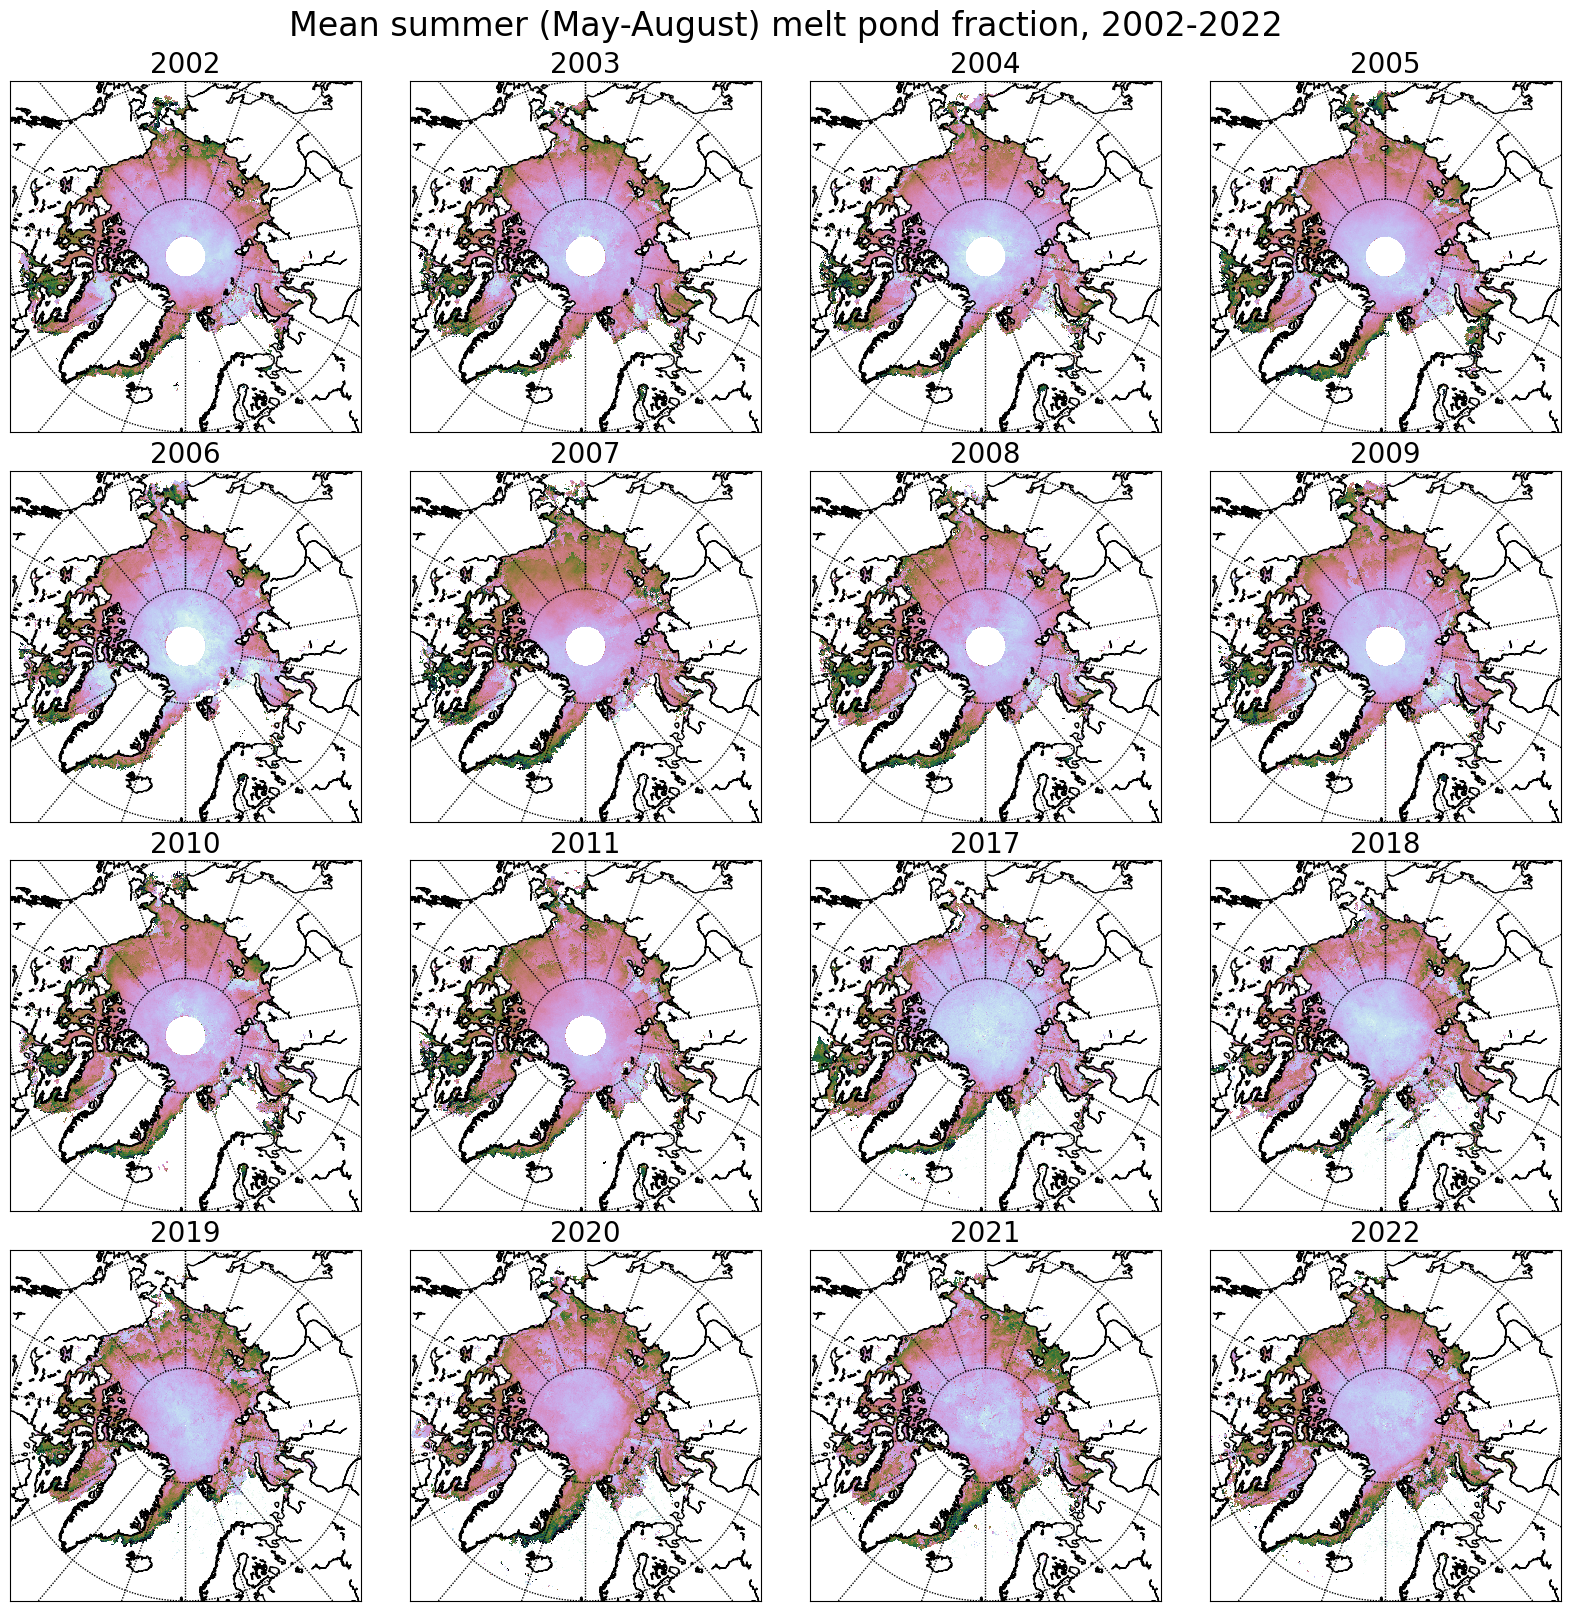

In [25]:
YEARS = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2017, 2018, 2019, 2020, 2021, 2022]

fig = plt.figure(figsize=(16,16), layout='constrained')
plt.set_cmap('cubehelix_r')

for i in range(len(YEARS)):
    year = YEARS[i]
    print(f'{year}...')

    # load monthly meltpond fractions
    if year >= 2017 and year <= 2023:
        data_dir = 'OLCI/olci'
    elif year >= 2002 and year <= 2011:
        data_dir = 'MERIS/mecosi'

    may_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_05_{year}.npy').ravel()
    jun_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_06_{year}.npy').ravel()
    jul_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_07_{year}.npy').ravel()
    aug_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_08_{year}.npy').ravel()
    #sep_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_09_{year}.npy').ravel()
    
   # calculate mean
    mpf = np.zeros([4,len(may_mpf)])
    np.shape(mpf)
    mpf[0,:] = may_mpf
    mpf[1,:] = jun_mpf
    mpf[2,:] = jul_mpf
    mpf[3,:] = aug_mpf
    #mpf[4,:] = sep_mpf
    mean_mpf = np.nanmean(mpf, axis=0)

    ax = fig.add_subplot(4,4,i+1)
    ax.set_title(f'{year}', fontsize=20)
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))

    lon_map,lat_map = m(mpf_lon,mpf_lat)
    m.pcolormesh(lon_map, lat_map, mean_mpf.reshape(896,608)*100, vmin=0, vmax=60)

plt.suptitle('Mean summer (May-August) melt pond fraction, 2002-2022', fontsize=24)
plt.show()


### Sea-Ice Roughness

Plot April SIR for 2010 and 2020.

In [23]:
SIR_2010, lon, lat, x, y = load_MISR(2010)
SIR_2020, _, _, _, _ = load_MISR(2020)


With axes:

/tmp/ipykernel_355748/706937660.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lon_map, lat_map, SIR_2010, vmin=0, vmax=0.2)
/tmp/ipykernel_355748/706937660.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cbar=plt.colorbar(plt.pcolormesh(lon_map, lat_map, SIR_2020, vmin=0, vmax=0.2), shrink=0.7)


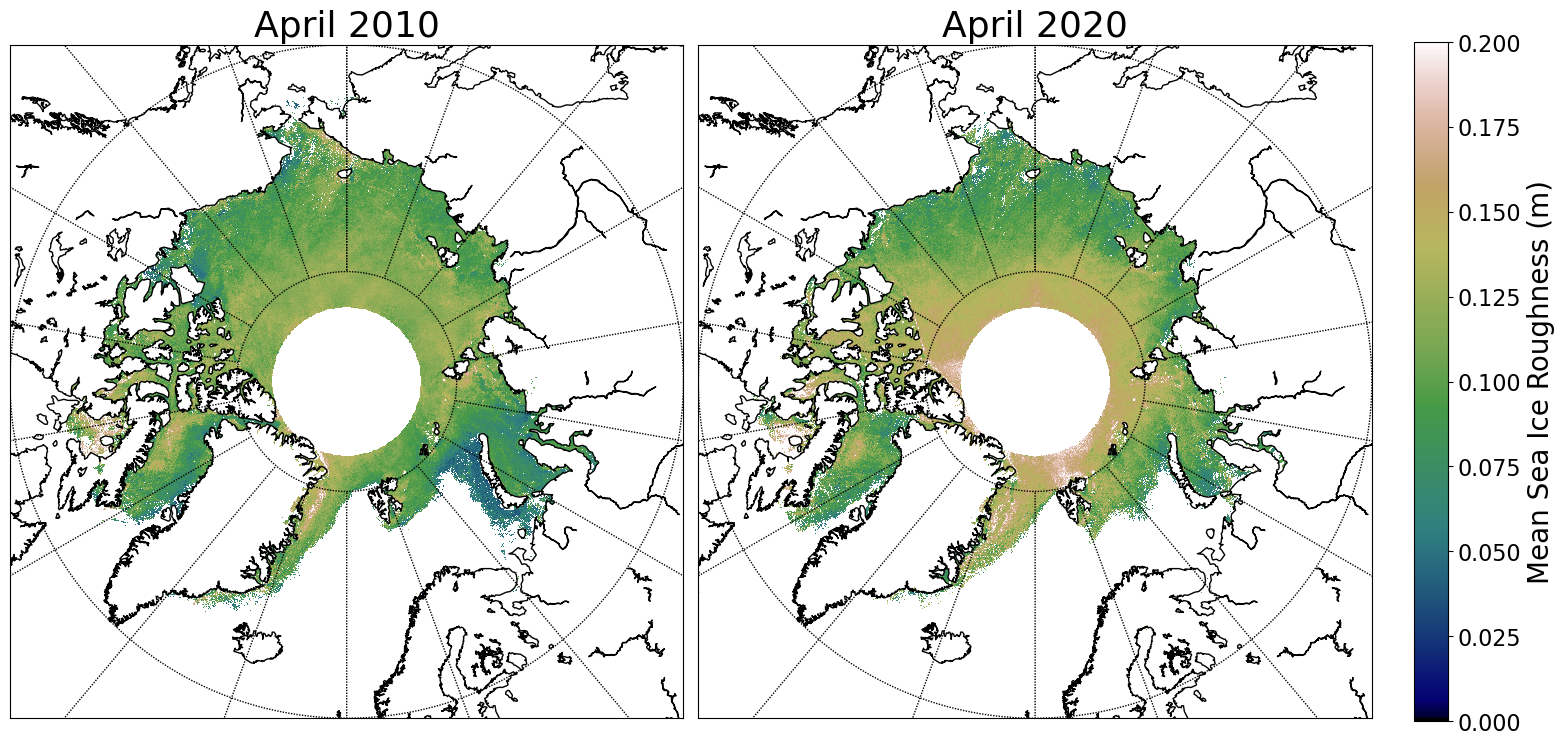

<Figure size 640x480 with 0 Axes>

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(16,10), gridspec_kw={'width_ratios': [0.8, 1]})
plt.set_cmap('gist_earth')

ax[0].set_title(f'April 2010', fontsize=26)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l', ax=ax[0])
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
lon_map,lat_map = m(lon,lat)
m.pcolormesh(lon_map, lat_map, SIR_2010, vmin=0, vmax=0.2)


ax[1].set_title(f'April 2020', fontsize=26)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l', ax=ax[1])
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
cbar=plt.colorbar(plt.pcolormesh(lon_map, lat_map, SIR_2020, vmin=0, vmax=0.2), shrink=0.7)
cbar.set_label('Mean Sea Ice Roughness (m)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

fig.tight_layout()
plt.show()
plt.savefig('/home/htweedie/melt_ponds/report_figs/roughness_sample.png', format='png')


With subplots:

/tmp/ipykernel_223860/4270288466.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lon_map, lat_map, SIR_2010, vmin=0, vmax=0.2)
/tmp/ipykernel_223860/4270288466.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lon_map, lat_map, SIR_2020, vmin=0, vmax=0.2)


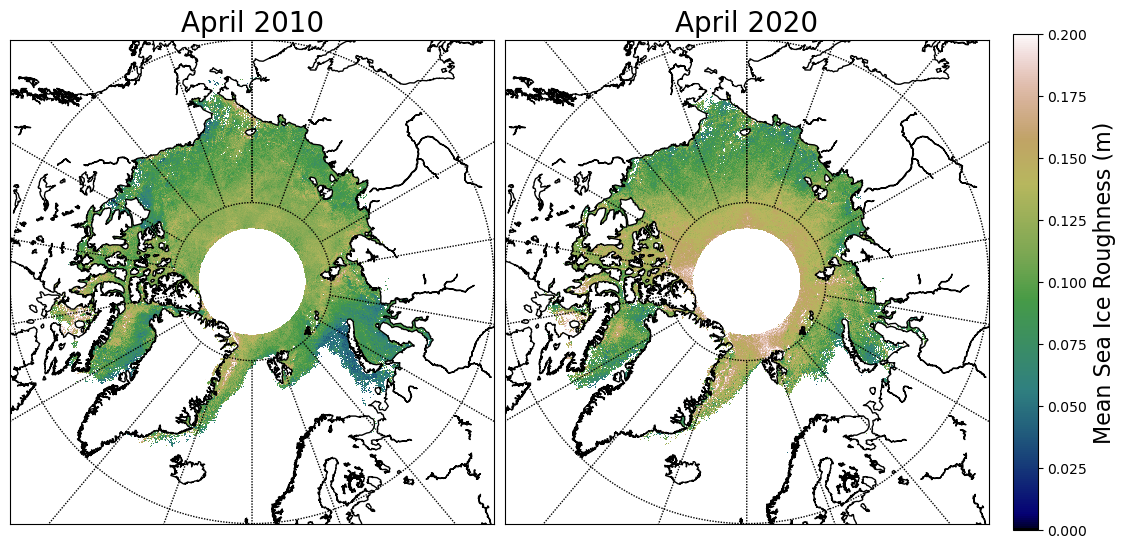

<Figure size 640x480 with 0 Axes>

In [37]:
fig = plt.figure(figsize=(16,10), layout='constrained')
plt.set_cmap('gist_earth')

ax = fig.add_subplot(131)
ax.set_title(f'April 2010', fontsize=20)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

lon_map,lat_map = m(lon,lat)
m.pcolormesh(lon_map, lat_map, SIR_2010, vmin=0, vmax=0.2)


ax = fig.add_subplot(132)
ax.set_title(f'April 2020', fontsize=20)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

m.pcolormesh(lon_map, lat_map, SIR_2020, vmin=0, vmax=0.2)
cbar=plt.colorbar(shrink=0.5)
cbar.set_label('Mean Sea Ice Roughness (m)', fontsize=16)

plt.show()
plt.savefig('/home/htweedie/melt_ponds/report_figs/roughness_sample.png', format='png')


### Ice Advection

In [3]:
YEAR = 2020

# load advected coordinates
lat_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lat_from_{YEAR}0401_183 days_spacing_8.pkl')
print(f'Latitudes retrieved. Shape: {lat_advected.shape}')
lon_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lon_from_{YEAR}0401_183 days_spacing_8.pkl')
print(f'Longitudes retrieved. Shape: {lon_advected.shape}')


MPF retrieved. Shape: (184, 1000000)
Latitudes retrieved. Shape: (184, 1000000)
Longitudes retrieved. Shape: (184, 1000000)


In [5]:
def format_date(year, month, day):
    return f"{year}-{month}-{day} 12:00:00"

# subset full mpf dataframe to retrieve just the days to average
date_from = format_date(YEAR, '04', '01')
date_to = format_date(YEAR, '09', '01')

start_lons = lon_advected.loc[date_from]
start_lats = lat_advected.loc[date_from]

end_lons = lon_advected.loc[date_to]
end_lats = lat_advected.loc[date_to]


### Predictions

In [7]:
path = '/home/htweedie/melt_ponds/processed_results'

observed_mpfs = np.load(f'{path}/observed_mpfs.npy')
adv_pred = np.load(f'{path}/adv_pred.npy')
stat_pred = np.load(f'{path}/stat_pred.npy')
adv_pred_bins = np.load(f'{path}/adv_pred_bins.npy')
stat_pred_bins = np.load(f'{path}/stat_pred_bins.npy')
adv_corr_coeffs = np.load(f'{path}/adv_corr_coeffs.npy')
stat_corr_coeffs = np.load(f'{path}/stat_corr_coeffs.npy')
adv_obs_mpf_subset = read_list(f'{path}/adv_obs_mpf_subset.pkl')
adv_pred_subset = read_list(f'{path}/adv_pred_subset.pkl')
stat_obs_mpf_subset = read_list(f'{path}/stat_obs_mpf_subset.pkl')
stat_pred_subset = read_list(f'{path}/stat_pred_subset.pkl')


Static:

/tmp/ipykernel_355748/3028028543.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_355748/2827807996.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([0, 20, 40, 60, 80, 100])
/tmp/ipykernel_355748/2827807996.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([0, 20, 40, 60, 80, 100])
/tmp/ipykernel_355748/3028028543.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_355748/2827807996.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([0, 20, 40, 60, 80, 100])
/tmp/ipykernel_355748/2827807996.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

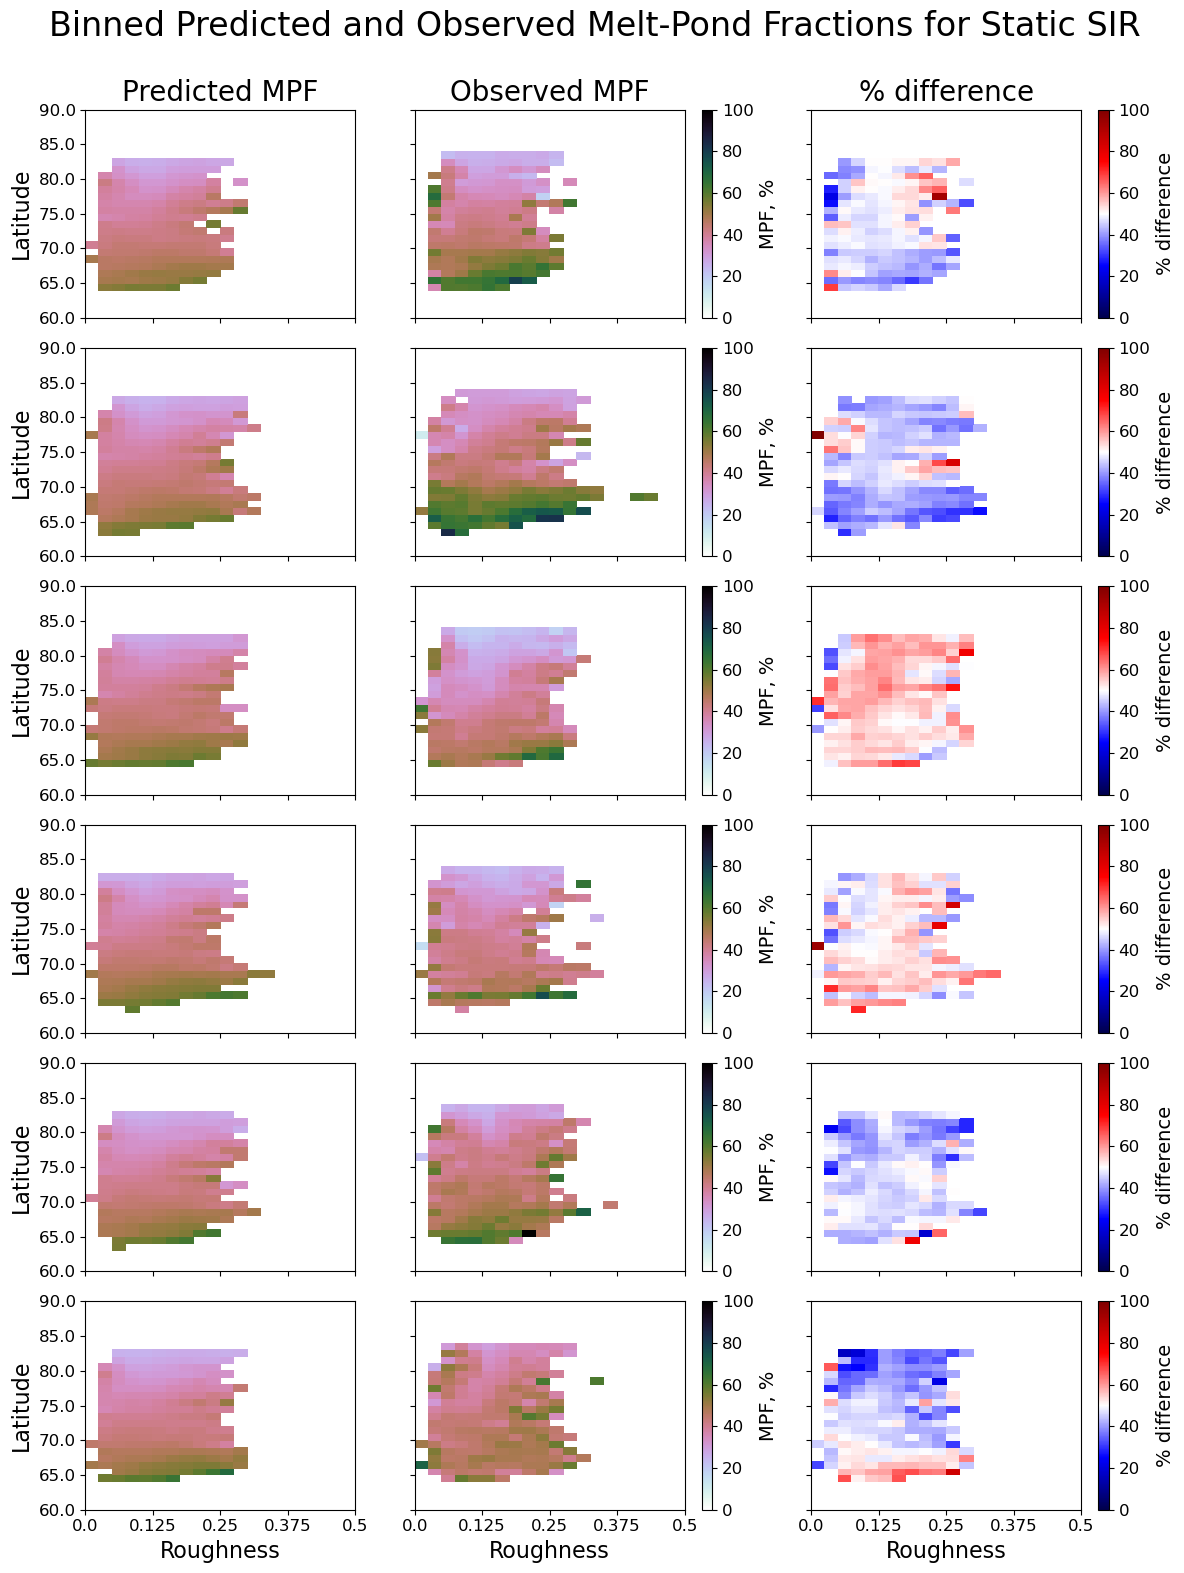

In [91]:
YEARS = [2010, 2011, 2017, 2018, 2019, 2020]

y_tick_positions = np.linspace(0, 30, 7) 
x_tick_positions = np.linspace(0, 20, 5)
y_tick_labels = np.linspace(60, 90, 7) 
x_tick_labels = np.linspace(0, 0.5, 5)

fig, ax = plt.subplots(6, 3, figsize=(12,16), gridspec_kw={'width_ratios': [0.8, 1, 1]})

for y in range(len(YEARS)):
    year = YEARS[y] 

    april_MISR, lon_MISR, lat_MISR, x_MISR, y_MISR = load_static_MISR(year)

    obs_stat = calculate_binned_averages(observed_mpfs[y], april_MISR, lat_MISR)

    ax[y,0].set_xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    ax[y,0].set_yticks(y_tick_positions, y_tick_labels)
    ax[y,0].set_ylabel("Latitude", fontsize=16)
    ax[y,0].pcolor(stat_pred_bins[y]*100, cmap='cubehelix_r', vmin=0, vmax=60)
    ax[y,0].tick_params(
        labelsize = 12
    )
    if y == 0:
        ax[y,0].set_title(f'Predicted MPF', fontsize=20)
    if y == 5:
        ax[y,0].set_xlabel('Roughness', fontsize=16)
    else:
        ax[y,0].tick_params(
            axis='x',          
            which='both',    
            top=False,  
            labelbottom=False)
        

    ax[y,1].set_xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    ax[y,1].set_yticks(y_tick_positions, y_tick_labels)
    ax[y,1].tick_params(
        axis='y',          
        which='both',      
        labelleft=False)
    ax[y,1].pcolor(obs_stat*100, cmap='cubehelix_r', vmin=0, vmax=60)
    if y == 0:
        ax[y,1].set_title(f'Observed MPF', fontsize=20)
    if y == 5:
        ax[y,1].set_xlabel('Roughness', fontsize=16)
        ax[y,1].tick_params(
            labelsize = 12
        )
    else:
        ax[y,1].tick_params(
            axis='x',          
            which='both',    
            top=False,  
            labelbottom=False)
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='cubehelix_r'), ax=ax[y,1])
    cbar.set_label('MPF, %', fontsize=14)
    cbar.set_ticklabels([0, 20, 40, 60, 80, 100]) 
    cbar.ax.tick_params(labelsize=12)


    ax[y,2].set_xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    ax[y,2].set_yticks(y_tick_positions, y_tick_labels)
    ax[y,2].tick_params(
        axis='y',          
        which='both',    
        top=False,  
        labelleft=False)
    ax[y,2].pcolor(perc_diff(stat_pred_bins[y], obs_stat), cmap='seismic', vmin=-100, vmax=100)
    if y == 0:
        ax[y,2].set_title(f'% difference', fontsize=20)
    if y == 5:
        ax[y,2].tick_params(
            labelsize = 12
        )
        ax[y,2].set_xlabel('Roughness', fontsize=16)
    else:
        ax[y,2].tick_params(
            axis='x',          
            which='both',    
            top=False,  
            labelbottom=False
        )
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='seismic'), ax=ax[y,2])
    cbar.set_label('% difference', fontsize=14)
    cbar.set_ticklabels([0, 20, 40, 60, 80, 100])
    cbar.ax.tick_params(labelsize=12)


plt.suptitle('Binned Predicted and Observed Melt-Pond Fractions for Static SIR\n', fontsize=24)
fig.tight_layout()
plt.show()


Advected:

/tmp/ipykernel_355748/3028028543.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_355748/3028028543.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_355748/3028028543.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_355748/3028028543.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_355748/3028028543.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_355748/3028028543.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)


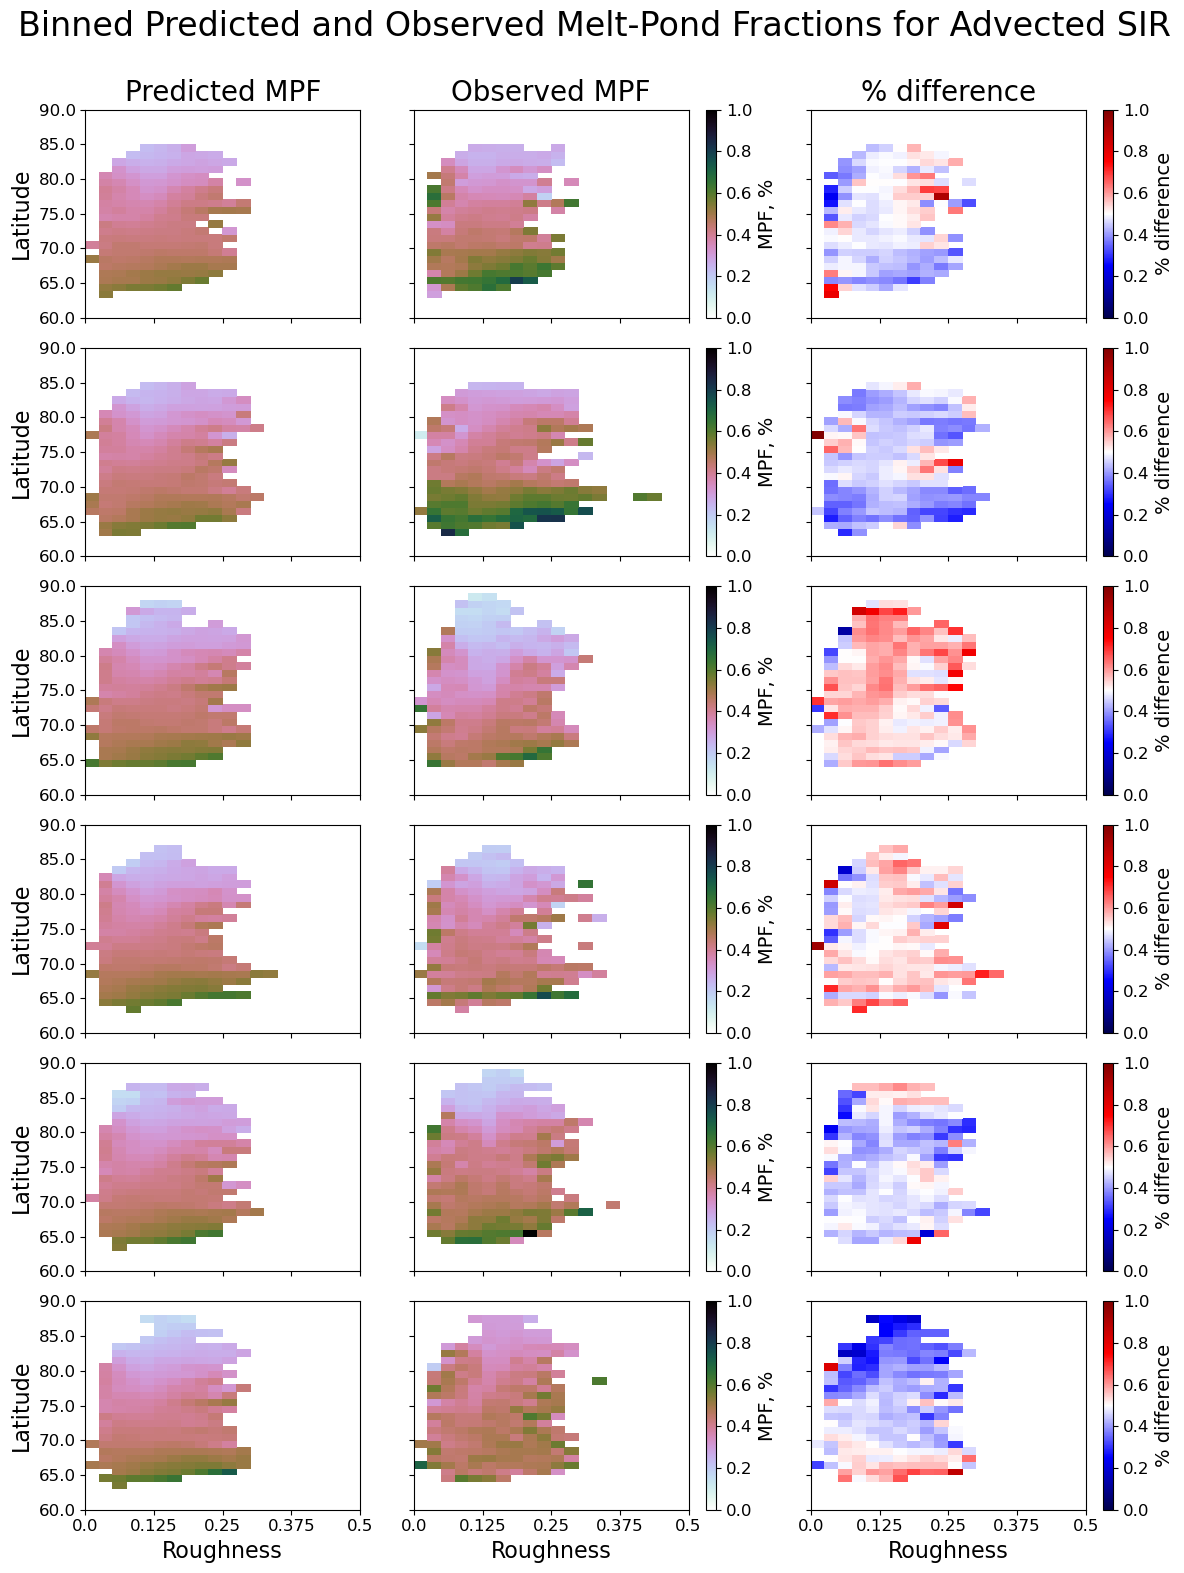

In [87]:
YEARS = [2010, 2011, 2017, 2018, 2019, 2020]

y_tick_positions = np.linspace(0, 30, 7) 
x_tick_positions = np.linspace(0, 20, 5)
y_tick_labels = np.linspace(60, 90, 7) 
x_tick_labels = np.linspace(0, 0.5, 5)

fig, ax = plt.subplots(6, 3, figsize=(12,16), gridspec_kw={'width_ratios': [0.8, 1, 1]})

for y in range(len(YEARS)):
    year = YEARS[y] 

    april_MISR, lon_MISR, lat_MISR, x_MISR, y_MISR = load_static_MISR(year)
    mean_advected_MISR = load_advected_MISR(year)

    obs_adv = calculate_binned_averages(observed_mpfs[y], mean_advected_MISR, lat_MISR)


    ax[y,0].set_xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    ax[y,0].set_yticks(y_tick_positions, y_tick_labels)
    ax[y,0].set_ylabel("Latitude", fontsize=16)
    ax[y,0].pcolor(adv_pred_bins[y]*100, cmap='cubehelix_r', vmin=0, vmax=60)
    ax[y,0].tick_params(
        labelsize = 12
    )
    if y == 0:
        ax[y,0].set_title(f'Predicted MPF', fontsize=20)
    if y == 5:
        ax[y,0].set_xlabel('Roughness', fontsize=16)
    else:
        ax[y,0].tick_params(
            axis='x',          
            which='both',    
            top=False,  
            labelbottom=False)
        

    ax[y,1].set_xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    ax[y,1].set_yticks(y_tick_positions, y_tick_labels)
    ax[y,1].tick_params(
        axis='y',          
        which='both',      
        labelleft=False)
    ax[y,1].pcolor(obs_adv*100, cmap='cubehelix_r', vmin=0, vmax=60)
    if y == 0:
        ax[y,1].set_title(f'Observed MPF', fontsize=20)
    if y == 5:
        ax[y,1].set_xlabel('Roughness', fontsize=16)
        ax[y,1].tick_params(
            labelsize = 12
        )
    else:
        ax[y,1].tick_params(
            axis='x',          
            which='both',    
            top=False,  
            labelbottom=False)
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='cubehelix_r'), ax=ax[y,1])
    cbar.set_label('MPF, %', fontsize=14)
    cbar.set_ticklabels([0, 20, 40, 60, 80, 100])
    cbar.ax.tick_params(labelsize=12)


    ax[y,2].set_xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    ax[y,2].set_yticks(y_tick_positions, y_tick_labels)
    ax[y,2].tick_params(
        axis='y',          
        which='both',    
        top=False,  
        labelleft=False)
    ax[y,2].pcolor(perc_diff(adv_pred_bins[y], obs_adv), cmap='seismic', vmin=-100, vmax=100)
    if y == 0:
        ax[y,2].set_title(f'% difference', fontsize=20)
    if y == 5:
        ax[y,2].tick_params(
            labelsize = 12
        )
        ax[y,2].set_xlabel('Roughness', fontsize=16)
    else:
        ax[y,2].tick_params(
            axis='x',          
            which='both',    
            top=False,  
            labelbottom=False
        )
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='seismic'), ax=ax[y,2])
    cbar.set_label('% difference', fontsize=14)
    cbar.set_ticklabels([0, 20, 40, 60, 80, 100])
    cbar.ax.tick_params(labelsize=12)


plt.suptitle('Binned Predicted and Observed Melt-Pond Fractions for Advected SIR\n', fontsize=24)
fig.tight_layout()
plt.show()


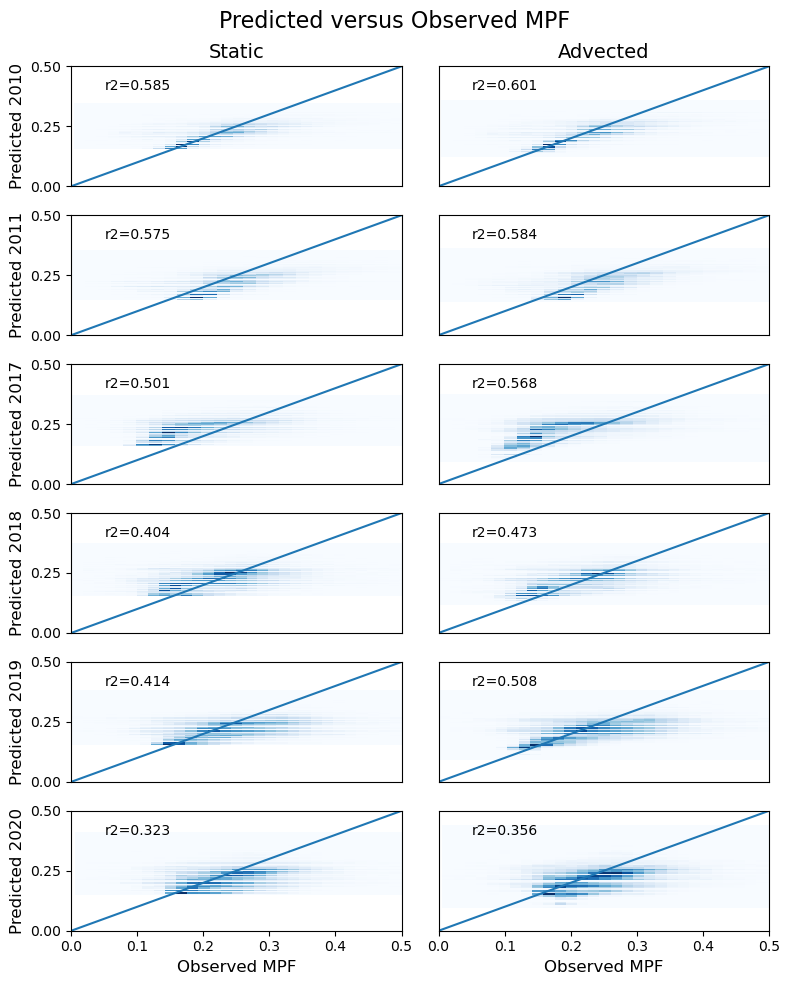

In [38]:
YEARS = [2010, 2011, 2017, 2018, 2019, 2020]

fig = plt.figure(figsize=(8,10))

for i in range(len(YEARS)):
    year = YEARS[i]

    plt.subplot(6,2,i*2+1)
    plt.hist2d(stat_obs_mpf_subset[i], stat_pred_subset[i], bins=(50,50), cmap='Blues')
    plt.xlim(0,0.5)
    plt.ylim(0,0.5)
    plt.axline((0, 0), slope=1)
    plt.ylabel(f'Predicted {year}', fontsize=12)
    plt.yticks([0, 0.25, 0.5])
    plt.text(0.05, 0.4, f'r2={np.round(stat_corr_coeffs[i],3)}')

    if i == 0:
        plt.title('Static', fontsize=14)
    if i == 5:
        plt.xlabel('Observed MPF', fontsize=12)
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

    plt.subplot(6,2,i*2+2)
    plt.hist2d(adv_obs_mpf_subset[i], adv_pred_subset[i], bins=(50,50), cmap='Blues')
    plt.xlim(0,0.5)
    plt.ylim(0,0.5)
    plt.axline((0, 0), slope=1)
    plt.text(0.05, 0.4, f'r2={np.round(adv_corr_coeffs[i],3)}')
    plt.tick_params(
            axis='y',          
            which='both',    
            left=False,  
            top=False,  
            labelleft=False)
    if i == 0:
        plt.title('Advected', fontsize=14)
    if i == 5:
        plt.xlabel('Observed MPF', fontsize=12)
    else:
        plt.tick_params(
            axis='x',          
            which='both',    
            bottom=False,  
            top=False,  
            labelbottom=False)

fig.subplots_adjust(left=0.15, top=0.95)
plt.suptitle(f'Predicted versus Observed MPF', fontsize=16)
fig.tight_layout()
plt.show()

plt.savefig('/home/htweedie/melt_ponds/report_figs/correlations.png')
